In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2> Vector Space Models

<h4> В данном ноутбуке для решения задачи ранжирования комментариев используются модели, которые основаны на смысловой схожести текста комментария и текста поста. Для оценки схожести текстов сначала переведём текста в векторное пространство, где каждому тексту будет соотвествовать свой вектор. Далее на основе мер близости векторов будем оценивать наиболее схожие по смыслу текста. В конце необходимо отранжировать комментарии на основе данной меры.
<h4> В ноутбуке представлены:
<h4> 1) Методы векторизации слов и текстов (TF-IDF, Word2vec, GloVe, BERT)
<h4> 2) Меры оценки близости векторов в пространстве (косинусная и евклидовы меры)
<h4> 3) Способы оценки качества модели (ndcg... to be continued)

In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import sys

import string
import nltk
nltk.download('punkt')

nltk.download('stopwords')
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h4> Все модели для векторизации и ранжирования комментариев описаны в файле vector_space_models_utils

In [3]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/VK_Hackaton")


In [4]:
import vector_space_models_utils
from vector_space_models_utils import rank_comments

<h4> Загрузка предобработанного датасета:

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VK_Hackaton/ranking_train.tsv', sep="\t")

In [6]:
import gensim.downloader

<h4> Создание токенизатора с небольшой предобработкой текста:

In [7]:
class NLTK_Tokenizer:
    def __init__(self, delete_punctuation=False, delete_stop_words=False):
        self.delete_punctuation = delete_punctuation
        self.delete_stop_words = delete_stop_words
    def tokenize(self, text, ):
        if self.delete_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.delete_stop_words:
            return [token for token in tokens if token not in stopWords]
        return tokens

nltk_tokenizer = NLTK_Tokenizer()

<h4> Создание экземпляра класса Embeddings_text_to_vector с описанными ранее embedding и tokenizer:

In [8]:
from vector_space_models_utils import Embeddings_text_to_vector
from vector_space_models_utils import get_predicted_order

<h4> Метрики оценки качества модели

In [9]:
from vector_space_models_utils import hits_score
from vector_space_models_utils import dcg_score
from vector_space_models_utils import get_ndcg
from sklearn.metrics import ndcg_score

<h2> Модель Word2vec

<h5> В данном разделе для перевода текстов комментариев и поста в вектора используются уже предобученные embedding из Word2vec.

<h5> Косинусная мера близости

In [ ]:
embeddings_list = [('word2vec-google-news-300', 300)]

print('Cosine similarity ranking:')
print()

for embedding_name, vector_dim in embeddings_list:
    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)
    current_vectorizer = Embeddings_text_to_vector(current_embeddings, current_tokenizer, vector_dim)

    predicted_orders = get_predicted_order(train_df, current_vectorizer)

    print(embedding_name)
    for k in range(1, 5):
        print(f'hits@{k}: {round(hits_score(predicted_orders, k=k), 2)}',
              f'dcg@{k}: {round(dcg_score(predicted_orders, k=k), 2)}',
              f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df), predicted_orders, k=k), 2)}')

Cosine similarity ranking:

word2vec-google-news-300
hits@1: 0.26 dcg@1: 0.26 ndcg@1: 0.58
hits@2: 0.51 dcg@2: 0.42 ndcg@2: 0.63
hits@3: 0.72 dcg@3: 0.52 ndcg@3: 0.68
hits@4: 0.88 dcg@4: 0.59 ndcg@4: 0.75


<h5> После тестирования с использованием косинусной меры близости:

| Embedding                 | top comment DCG@1 | top comment DCG@3 | top comment NDCG@1 | top comment NDCG@3 |
|----------                 |------             |------             |------              |------              |
| word2vec-google-news-300  |0.26               |0.52               |0.58                |0.68                |

<h5> Евклидовое расстояние

In [ ]:
embeddings_list = [('word2vec-google-news-300', 300)]

print('Euclidean distance ranking:')
print()

for embedding_name, vector_dim in embeddings_list:
    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)
    current_vectorizer = Embeddings_text_to_vector(current_embeddings, current_tokenizer, vector_dim)

    predicted_oredrs = get_predicted_order(train_df, current_vectorizer, rank_by='euclidian_distance')

    print(embedding_name)
    for k in range(1, 5):
        print(f'hits@{k}: {round(hits_score(predicted_orders, k=k), 2)}',
              f'dcg@{k}: {round(dcg_score(predicted_orders, k=k), 2)}',
              f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df), predicted_orders, k=k), 2)}')

Euclidean distance ranking:

word2vec-google-news-300
hits@1: 0.29 dcg@1: 0.29 ndcg@1: 0.6
hits@2: 0.54 dcg@2: 0.45 ndcg@2: 0.65
hits@3: 0.75 dcg@3: 0.55 ndcg@3: 0.7
hits@4: 0.9 dcg@4: 0.62 ndcg@4: 0.77


<h5> После тестирования с использованием евклидового расстояния :

| Embedding                 | top comment DCG@1 | top comment DCG@3 | top comment NDCG@1 | top comment NDCG@3 |
|----------                 |------             |------             |------              |------              |
| word2vec-google-news-300  |0.29               |0.55               |0.6                 |0.7                 |

<h2> Модель GloVe

<h5> В данном разделе для перевода текстов комментариев и поста в вектора используются уже предобученные embedding из GloVe.

<h5> Косинусная мера близости

In [ ]:
embeddings_list = [('glove-wiki-gigaword-50', 50), ('glove-wiki-gigaword-100', 100), ('glove-wiki-gigaword-200', 200),
                   ('glove-twitter-25', 25), ('glove-twitter-50', 50), ('glove-twitter-100', 100)]

print('Cosine similarity ranking:')
print()

for embedding_name, vector_dim in tqdm(embeddings_list):
    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)
    current_vectorizer = Embeddings_text_to_vector(current_embeddings, current_tokenizer, vector_dim)

    predicted_orders = get_predicted_order(train_df, current_vectorizer)

    print(embedding_name)
    for k in range(1, 5):
        print(f'hits@{k}: {round(hits_score(predicted_orders, k=k), 2)}',
              f'dcg@{k}: {round(dcg_score(predicted_orders, k=k), 2)}',
              f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df), predicted_orders, k=k), 2)}')

Cosine similarity ranking:



  0%|          | 0/6 [00:00<?, ?it/s]

glove-wiki-gigaword-50
hits@1: 0.24 dcg@1: 0.24 ndcg@1: 0.56
hits@2: 0.47 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.69 dcg@3: 0.49 ndcg@3: 0.66


 17%|█▋        | 1/6 [05:47<28:56, 347.23s/it]

hits@4: 0.87 dcg@4: 0.57 ndcg@4: 0.74
glove-wiki-gigaword-100
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.57
hits@2: 0.49 dcg@2: 0.4 ndcg@2: 0.61
hits@3: 0.7 dcg@3: 0.5 ndcg@3: 0.67


 33%|███▎      | 2/6 [11:32<23:04, 346.10s/it]

hits@4: 0.87 dcg@4: 0.58 ndcg@4: 0.74
glove-wiki-gigaword-200
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.57
hits@2: 0.49 dcg@2: 0.4 ndcg@2: 0.62
hits@3: 0.7 dcg@3: 0.51 ndcg@3: 0.67


 50%|█████     | 3/6 [18:06<18:24, 368.06s/it]

hits@4: 0.88 dcg@4: 0.58 ndcg@4: 0.74
glove-twitter-25
hits@1: 0.23 dcg@1: 0.23 ndcg@1: 0.55
hits@2: 0.46 dcg@2: 0.38 ndcg@2: 0.6
hits@3: 0.68 dcg@3: 0.49 ndcg@3: 0.66


 67%|██████▋   | 4/6 [23:40<11:49, 354.62s/it]

hits@4: 0.86 dcg@4: 0.56 ndcg@4: 0.73
glove-twitter-50
hits@1: 0.24 dcg@1: 0.24 ndcg@1: 0.56
hits@2: 0.47 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.69 dcg@3: 0.49 ndcg@3: 0.66


 83%|████████▎ | 5/6 [29:45<05:58, 358.27s/it]

hits@4: 0.87 dcg@4: 0.57 ndcg@4: 0.74
glove-twitter-100
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.57
hits@2: 0.49 dcg@2: 0.4 ndcg@2: 0.61
hits@3: 0.7 dcg@3: 0.5 ndcg@3: 0.67


100%|██████████| 6/6 [36:49<00:00, 368.28s/it]

hits@4: 0.87 dcg@4: 0.58 ndcg@4: 0.74


<h5> После тестирования различных embeddings на косинусной мере близости:

| Embedding                 | top comment DCG@1| top comment DCG@3| top comment NDCG@1 | top comment NDCG@3 |
|----------                 |------            |------            |------              |------              |
| glove-wiki-gigaword-50    | 0.24             | 0.49             | 0.56               | 0.66               |
| glove-wiki-gigaword-100   | 0.25             | 0.50             | 0.57               | 0.67               |
| glove-wiki-gigaword-200   | 0.25             | 0.51             | 0.57               | 0.67               |
| glove-twitter-25          | 0.23             | 0.49             | 0.55               | 0.66               |
| glove-twitter-50          | 0.24             | 0.49             | 0.56               | 0.66               |
| glove-twitter-100         | 0.25             | 0.50             | 0.57               | 0.67               |
| random                    | 0.20             | 0.43             |                    |                    |

In [ ]:
embeddings_list = [('glove-wiki-gigaword-50', 50), ('glove-wiki-gigaword-100', 100), ('glove-wiki-gigaword-200', 200),
                   ('glove-twitter-25', 25), ('glove-twitter-50', 50), ('glove-twitter-100', 100)]

print('Euclidean distance ranking:')
print()

for embedding_name, vector_dim in tqdm(embeddings_list):
    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)
    current_vectorizer = Embeddings_text_to_vector(current_embeddings, current_tokenizer, vector_dim)

    predicted_orders = get_predicted_order(train_df, current_vectorizer, rank_by='euclidian_distance')

    print(embedding_name)
    for k in range(1, 5):
        print(f'hits@{k}: {round(hits_score(predicted_orders, k=k), 2)}',
              f'dcg@{k}: {round(dcg_score(predicted_orders, k=k), 2)}',
              f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df), predicted_orders, k=k), 2)}')

Euclidean distance ranking:



  0%|          | 0/6 [00:00<?, ?it/s]

glove-wiki-gigaword-50
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.58
hits@2: 0.5 dcg@2: 0.41 ndcg@2: 0.62
hits@3: 0.71 dcg@3: 0.51 ndcg@3: 0.68


 17%|█▋        | 1/6 [04:34<22:52, 274.46s/it]

hits@4: 0.88 dcg@4: 0.59 ndcg@4: 0.75
glove-wiki-gigaword-100
hits@1: 0.27 dcg@1: 0.27 ndcg@1: 0.59
hits@2: 0.51 dcg@2: 0.42 ndcg@2: 0.63
hits@3: 0.72 dcg@3: 0.53 ndcg@3: 0.69


 33%|███▎      | 2/6 [09:20<18:44, 281.01s/it]

hits@4: 0.89 dcg@4: 0.6 ndcg@4: 0.75
glove-wiki-gigaword-200
hits@1: 0.27 dcg@1: 0.27 ndcg@1: 0.59
hits@2: 0.52 dcg@2: 0.43 ndcg@2: 0.64
hits@3: 0.73 dcg@3: 0.54 ndcg@3: 0.69


 50%|█████     | 3/6 [14:52<15:13, 304.45s/it]

hits@4: 0.89 dcg@4: 0.61 ndcg@4: 0.76
glove-twitter-25
hits@1: 0.24 dcg@1: 0.24 ndcg@1: 0.56
hits@2: 0.48 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.69 dcg@3: 0.5 ndcg@3: 0.67


 67%|██████▋   | 4/6 [20:01<10:12, 306.40s/it]

hits@4: 0.87 dcg@4: 0.58 ndcg@4: 0.74
glove-twitter-50
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.57
hits@2: 0.5 dcg@2: 0.41 ndcg@2: 0.62
hits@3: 0.71 dcg@3: 0.51 ndcg@3: 0.68


 83%|████████▎ | 5/6 [25:52<05:22, 322.26s/it]

hits@4: 0.88 dcg@4: 0.59 ndcg@4: 0.75
glove-twitter-100
hits@1: 0.27 dcg@1: 0.27 ndcg@1: 0.58
hits@2: 0.51 dcg@2: 0.42 ndcg@2: 0.63
hits@3: 0.72 dcg@3: 0.53 ndcg@3: 0.69


100%|██████████| 6/6 [32:33<00:00, 325.51s/it]

hits@4: 0.89 dcg@4: 0.6 ndcg@4: 0.75


<h5> После тестирования различных embeddings по евклидовому расстоянию:

| Embedding                 | top comment DCG@1| top comment DCG@3| top comment NDCG@1 | top comment NDCG@3 |
|----------                 |------            |------            |------              |------              |
| glove-wiki-gigaword-50    | 0.25             | 0.71             | 0.25               | 0.51               |
| glove-wiki-gigaword-100   | 0.27             | 0.72             | 0.27               | 0.53               |
| glove-wiki-gigaword-200   | 0.27             | 0.73             | 0.27               | 0.54               |
| glove-twitter-25          | 0.24             | 0.69             | 0.24               | 0.5               |
| glove-twitter-50          | 0.25             | 0.71             | 0.15               | 0.66               |
| glove-twitter-100         | 0.25             | 0.50             | 0.57               | 0.67               |
| random                    | 0.20             | 0.43             |                    |                    |

<h5>Получен результат, что увеличение размерности векторного представления слова не приводит к сильному улучшению результата.

<h5>В данном случае результат на embeddings из текстов википедии или твиттера сопоставим, embeddings из википедии отработали незначительно лучше.

<h5>На ранжирование всей обучающей выборки уходит примерно 200-250 с

<h2> Tf-IDF vectorization

<h5> В данном разделе используются Tf-IDF вектора для векторизации текста

<h5> Загрузка корпус документов, состоящий из текстов и постов, и комментариев:

In [ ]:
corpus = []
for i in range(len(train_df)):
    for column in train_df.columns:
        corpus.append(train_df.loc[i][column])

<h5> Преобработка документов в корпусе:
<h5> - удаление пунктуации
<h5> - удаление стоп-слов, так как у них получится почти нулевой IDF
<h5> - стемминг текста, чтобы уменьшить размерность векторов

In [ ]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [ ]:
class Tokenizer_with_stemming:
    def __init__(self, delete_punctuation=False, delete_stop_words=False):
        self.delete_punctuation = delete_punctuation
        self.delete_stop_words = delete_stop_words
    def tokenize(self, text, ):
        if self.delete_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.delete_stop_words:
            return [ps.stem(token) for token in tokens if token not in stopWords and token.isalpha()]
        return tokens

tokenizer_with_stemming = Tokenizer_with_stemming(delete_punctuation=True, delete_stop_words=True)

In [ ]:
for i in tqdm(range(len(corpus))):
    corpus[i] = ' '.join(tokenizer_with_stemming.tokenize(corpus[i]))

100%|██████████| 528642/528642 [09:53<00:00, 890.46it/s] 


<h5> Далее используется библиотека sklearn для подсчёта IDF слов в корпусе документов:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(use_idf=True)
tf_idf_vectorizer.fit(corpus)
idf_dict = dict(zip(tf_idf_vectorizer.get_feature_names_out(), tf_idf_vectorizer.idf_))

In [ ]:
print(f'Длины векторов: {len(idf_dict)}')

Длины векторов: 547952


<h5> Распределение IDF:

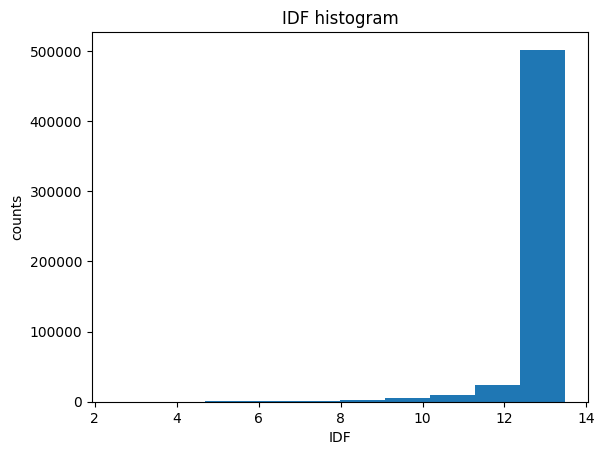

In [ ]:
plt.hist(idf_dict.values())
plt.xlabel('IDF')
plt.ylabel('counts')
plt.title('IDF histogram')
plt.show()

In [ ]:
print(f'Слова, которые встречаются всего в одном документе, имеют IDF = {np.log(len(corpus))}')

Слова, которые встречаются всего в одном документе, имеют IDF = 13.178066733160517


In [ ]:
keys_to_del = []

for key in idf_dict.keys():
    if idf_dict[key] > 13:
        keys_to_del.append(key)

for key in keys_to_del:
    idf_dict.pop(key)

In [ ]:
print(f'Длины векторов после обработки: {len(idf_dict)}')

Длины векторов после обработки: 86779


<h5> Удаление слов, которые встречаются всего в одном документе, так как, скорее всего, это просто мусор или опечатки

<h5> Создание экземпляр класса Tf_idf_vectorizer:

In [ ]:
from vector_space_models_utils import Tf_idf_vectorizer

In [ ]:
our_tf_idf_vectorizer = Tf_idf_vectorizer(idf_dict, tokenizer_with_stemming)

<h5> Оценка качества модели, так как подсчёт tf и операции с векторами большой размерности занимают много времени, используются каждый 50 пост и его комментарии:

In [ ]:
tf_idf_predicted_orders =  get_predicted_order(train_df[::50].reset_index(), our_tf_idf_vectorizer)

In [ ]:
print('Tf-IDF scores (cosine_similarity):')

for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(tf_idf_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(tf_idf_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df), tf_idf_predicted_orders, k=k), 2)}')

Tf-IDF scores:
hits@1: 0.2189449801474759, dcg@1: 0.2189449801474759
hits@2: 0.42824730572887126, dcg@2: 0.35100004484847874
hits@3: 0.5887691435053886, dcg@3: 0.43126096373673617
hits@4: 0.6931366988088485, dcg@4: 0.4762096232293648


<h5> Для Tf-IDF подхода получено качество:

| Method                    | DCG@1| DCG@3|
|----------                 |------|------|
| Tf-IDF vectors            | 0.22 | 0.43 |
| random                    | 0.20 | 0.43 |

<h5> Score на методе, основанном, на Tf-IDF векторах лишь незначительно лучше алгоритма, который бы случайно предсказывал порядок комментариев.

# BERT model

<h5> В данном разделе вектор текста получается из латентных слоёв модели BERT:

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model.eval().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

<h5> Создание экземпляра класса BERT_vectorizer:

In [ ]:
from vector_space_models_utils import BERT_vectorizer

In [ ]:
bert_vectorizer = BERT_vectorizer(bert_model, bert_tokenizer)

<h5> Оценка качества модели:

In [ ]:
bert_predicted_orders = get_predicted_order(train_df[:5000], bert_vectorizer)

print('BERT-based vectors scores:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(bert_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(bert_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), bert_predicted_orders, k=k), 2)}')

BERT-based vectors scores:
hits@1: 0.19 dcg@1: 0.19 ndcg@1: 0.53
hits@2: 0.38 dcg@2: 0.31 ndcg@2: 0.58
hits@3: 0.6 dcg@3: 0.42 ndcg@3: 0.63
hits@4: 0.82 dcg@4: 0.51 ndcg@4: 0.71


In [ ]:
bert_predicted_orders = get_predicted_order(train_df[:5000], bert_vectorizer, rank_by='euclidian_distance')

print('BERT-based vectors scores:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(bert_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(bert_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), bert_predicted_orders, k=k), 2)}')

BERT-based vectors scores:
hits@1: 0.18 dcg@1: 0.18 ndcg@1: 0.53
hits@2: 0.4 dcg@2: 0.32 ndcg@2: 0.58
hits@3: 0.62 dcg@3: 0.43 ndcg@3: 0.64
hits@4: 0.83 dcg@4: 0.52 ndcg@4: 0.71


<h2> SentenceTransformer models

In [24]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=c436bf0f2e7cf2735bb75b6432ae09a59dfd5505eefc91521c377b864b4d3285
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [25]:
from sentence_transformers import SentenceTransformer
from vector_space_models_utils import Sentense_transformers_vectorizer

#Модель DistilBERT

In [ ]:
distilbert_model = SentenceTransformer('multi-qa-distilbert-cos-v1')
distilbert_vectorizer = Sentense_transformers_vectorizer(distilbert_model)

In [ ]:
distilbert_predicted_orders = get_predicted_order(train_df[:5000], distilbert_vectorizer)

print('DistilBERT-based vectors scores with cosine-similarity:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(distilbert_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(distilbert_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), distilbert_predicted_orders, k=k), 2)}')

DistilBERT-based vectors scores with cosine-similarity:
hits@1: 0.24 dcg@1: 0.24 ndcg@1: 0.56
hits@2: 0.48 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.68 dcg@3: 0.49 ndcg@3: 0.66
hits@4: 0.85 dcg@4: 0.56 ndcg@4: 0.74


In [ ]:
distilbert_predicted_orders = get_predicted_order(train_df[:5000], distilbert_vectorizer, rank_by='euclidian_distance')

print('DistilBERT-based vectors scores with euclidean distance:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(distilbert_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(distilbert_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), distilbert_predicted_orders, k=k), 2)}')

DistilBERT-based vectors scores with euclidean distance:
hits@1: 0.24 dcg@1: 0.24 ndcg@1: 0.56
hits@2: 0.48 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.68 dcg@3: 0.49 ndcg@3: 0.66
hits@4: 0.85 dcg@4: 0.56 ndcg@4: 0.74


#Модель Distilroberta

In [ ]:
distilroberta_model = SentenceTransformer('all-distilroberta-v1')
distilroberta_vectorizer = Sentense_transformers_vectorizer(distilroberta_model)

In [ ]:
distilroberta_predicted_orders = get_predicted_order(train_df[:5000], distilroberta_vectorizer)

print('Distilroberta-based vectors scores with cosine similarity:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(distilroberta_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(distilroberta_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), distilroberta_predicted_orders, k=k), 2)}')

Distilroberta-based vectors scores with cosine similarity:
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.56
hits@2: 0.49 dcg@2: 0.4 ndcg@2: 0.61
hits@3: 0.69 dcg@3: 0.5 ndcg@3: 0.67
hits@4: 0.86 dcg@4: 0.57 ndcg@4: 0.74


In [ ]:
distilroberta_predicted_orders = get_predicted_order(train_df[:5000], distilroberta_vectorizer, rank_by='euclidian_distance')

print('Distilroberta-based vectors scores with euclidean distance:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(distilroberta_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(distilroberta_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), distilroberta_predicted_orders, k=k), 2)}')

Distilroberta-based vectors scores with euclidean distance:
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.56
hits@2: 0.49 dcg@2: 0.4 ndcg@2: 0.61
hits@3: 0.69 dcg@3: 0.5 ndcg@3: 0.67
hits@4: 0.86 dcg@4: 0.57 ndcg@4: 0.74


#Модель: all-mpnet-base-v2


In [26]:
all_mpnet_model = SentenceTransformer('all-mpnet-base-v2')
all_mpnet_vectorizer = Sentense_transformers_vectorizer(all_mpnet_model)

In [27]:
all_mpnet_predicted_orders = get_predicted_order(train_df[:5000], all_mpnet_vectorizer)

print('Distilroberta-based vectors scores with cosine similarity:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(all_mpnet_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(all_mpnet_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), all_mpnet_predicted_orders, k=k), 2)}')

Distilroberta-based vectors scores with cosine similarity:
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.56
hits@2: 0.48 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.68 dcg@3: 0.49 ndcg@3: 0.67
hits@4: 0.86 dcg@4: 0.57 ndcg@4: 0.74


In [28]:
all_mpnet_predicted_orders = get_predicted_order(train_df[:5000], all_mpnet_vectorizer, rank_by='euclidian_distance')

print('Distilroberta-based vectors scores with cosine similarity:')
for k in range(1, 5):
    print(f'hits@{k}: {round(hits_score(all_mpnet_predicted_orders, k=k), 2)}',
          f'dcg@{k}: {round(dcg_score(all_mpnet_predicted_orders, k=k), 2)}',
          f'ndcg@{k}: {round(ndcg_score([[0, 1, 2, 3, 4]] * len(train_df[:5000]), all_mpnet_predicted_orders, k=k), 2)}')

Distilroberta-based vectors scores with cosine similarity:
hits@1: 0.25 dcg@1: 0.25 ndcg@1: 0.56
hits@2: 0.48 dcg@2: 0.39 ndcg@2: 0.61
hits@3: 0.68 dcg@3: 0.49 ndcg@3: 0.67
hits@4: 0.86 dcg@4: 0.57 ndcg@4: 0.74


In [ ]:
from imp import reload

reload(vector_space_models_utils)

<module 'vector_space_models_utils' from '/content/drive/MyDrive/Colab Notebooks/VK_hackaton/vector_space_models_utils.py'>